In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import scipy
import scipy.ndimage.filters

In [2]:
#pip install nengo

In [3]:
#pip install nengo-ocl

In [2]:
import nengo
from scipy.fftpack import idst,dst
type = 2
def denom_matrix(n_row,n_col):
    x = np.linspace(1, n_col, n_col)
    y = np.linspace(1, n_row,n_row)
    xv, yv = np.meshgrid(x, y)

    return np.transpose(((2*np.cos(np.pi*xv/(n_col+1))-2) + (2*np.cos(np.pi*yv/(n_row+1)) - 2)).flatten()) 

def DST_matrix(h,w,dim ='row'): 
    if(dim == 'row'):
        d = dst(np.eye(h), axis=0,type = type)
        return np.kron(np.eye(w),d)
    else:
        d = dst(np.eye(w), axis=0,type = type)
        return np.kron(np.eye(h),d)   

def IDST_matrix(h,w,dim ='row'): 
    if(dim == 'row'): 
        d = idst(np.eye(h), axis=0,type = type)
        return np.kron(np.eye(w),d)
    else:
        d = idst(np.eye(w), axis=0,type = type)
        return np.kron(np.eye(h),d)

def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1J / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W 

def transform_2d(n_row,n_col):
    n = np.arange(0,n_row*n_col)
    
    w = np.zeros((n_row*n_col,n_row*n_col))
    n1 = np.transpose(np.reshape(n,(n_row,n_col))).flatten()
    j = 0
    for i in n1:        
        w[i,j] = 1
        j = j+1
    return w.T   

In [3]:
def create_weights(h,w):
    tr_2d = transform_2d(h,w)
    w_dst_r = DST_matrix(h,w)
    w_dst_c = DST_matrix(h,w,dim='col')
    w_idst_r = IDST_matrix(h,w)
    w_idst_c = IDST_matrix(h,w,dim='col')
    w_dem = denom_matrix(h,w) 
    W =  tr_2d.T @ w_idst_r @ tr_2d @ w_idst_c @ np.diag((1/w_dem)) @ tr_2d.T @ w_dst_r @ tr_2d @ w_dst_c
    del tr_2d,w_dst_r,w_dst_c,w_idst_c,w_idst_r,w_dem 
    W = W - np.min(W)
    W = W/np.max(W)
    return W

In [4]:
from nengo.utils.matplotlib import rasterplot
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
def get_image_channels(rgb):

    r, g, b = 1.0*rgb[:,:,0], 1.0*rgb[:,:,1], 1.0*rgb[:,:,2]
    return r,g,b    

def save_results(data,h,w,image_name):
    t = 200
    #out_img = np.reshape(sim.data[out1][t], (h, w))
    out_img = np.reshape(data[t], (h, w))
    plt.figure()

    plt.imshow(out_img,cmap = 'gray')
    path = 'ab_feedforward_' + image_name + '_' + str(t) + '.png'
    mpimg.imsave(path,out_img,cmap='gray')  

def save_spikes(data,image_name,n,title):
    t = 500
    center_pixels = np.arange(np.round(n/2)-50,np.round(n/2)+50,dtype = np.int32)
    fig, ax = plt.subplots(1, 1, sharex=True  )
    

    ax.set_title(title + ": Spikes Raster")
    rasterplot(np.arange(t),data[0:t,center_pixels], ax=ax)
    ax.set_ylabel("Neuron #")
    ax.set_xlabel("Time (ms)")
    fig.show()
    plt.savefig('ab_feedforward_Spikes_Raster_'+image_name+ '_' + str(t) +'.png')
    np.save('ab_feedforward_Spikes_Raster_'+ image_name+ '.npy',data[0:t])
   
   

In [5]:
import nengo_ocl
def run_feedforward_model(img,img_name,img_title):
    h,w = img.shape
    W = create_weights(h,w)
    model = nengo.Network()
    n = h*w
    n_neurons_ens = 20
    with model:


        def stim_gray(t):
            return -1*scipy.ndimage.filters.laplace(255*img).flatten()
            
        
        inp = nengo.Node(stim_gray)
    


        layer = nengo.networks.EnsembleArray(n_neurons_ens, n,
                                            neuron_type= nengo.SpikingRectifiedLinear()
                                            )
                                                                            
        layer_out = nengo.networks.EnsembleArray(n_neurons_ens, n,
                                                neuron_type= nengo.SpikingRectifiedLinear()
                                                )
        nengo.Connection(inp,layer.input)
        nengo.Connection(layer.output,layer_out.input,transform=(1-W))

        
    
        layer_out.add_neuron_output()
        img_spikes =  nengo.Probe(layer_out.neuron_output, synapse=None)

        
        out1 = nengo.Probe(layer_out.output)
    

    print(model.n_neurons)  

    with nengo_ocl.Simulator(model, progress_bar =False) as sim:  # Create the simulator
        sim.run(2)

    save_results(sim.data[out1],h,w,img_name) 
    save_spikes(sim.data[img_spikes],img_name,n,img_title)
    
    return sim.data[out1],sim.data[img_spikes]

300000
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:
392000


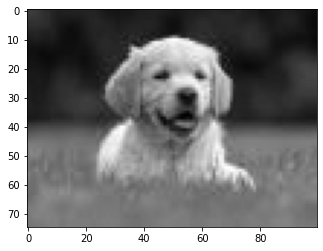

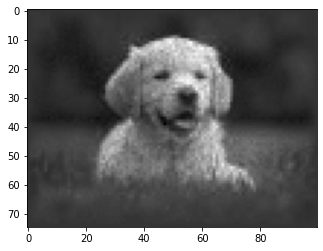

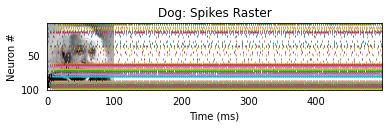

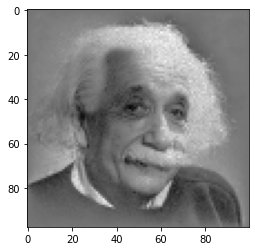

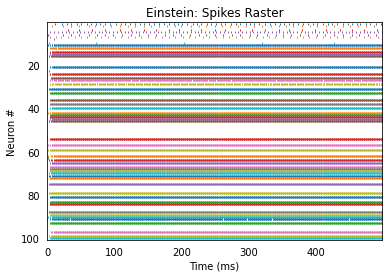

In [6]:
image_list = []
image_list.append(['black_squre_100_97','png','Black square'])
image_list.append(['dog_p_100_75','jpg','Dog'])
image_list.append(['einstein_p_100_98','png','Einstein'])
image_list.append(['BerryJ_100_67','jpg','Landscape'])


for inx in range(len(image_list)):

    # read image
    img_name = image_list[inx][0]
    img_ext = image_list[inx][1]
    img_title = image_list[inx][2]
    img_path = img_name +'.' + img_ext
    img = rgb2gray(mpimg.imread(img_path) )
    img = img/np.max(img)
    plt.imshow(img, cmap='gray')
   
    data,spikes = run_feedforward_model(img,img_name,img_title)